In [1]:
import pandas as pd
from datetime import datetime
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
data = pd.read_csv(r'D:\Code\DS108\preprocessing\tidy_data.csv', encoding = 'utf-8-sig')

In [3]:
# Số dòng và cột của dữ liệu
data.shape

(13224, 27)

In [4]:
# Các thuộc tính của dữ liệu
data.columns

Index(['name', 'brand', 'condition', 'price_old', 'price_new', 'warranty',
       'CPU', 'RAM', 'capacity', 'time', 'battery', 'screen_size',
       'operating_system', 'display_technology', 'weight', 'bluetooth',
       'refresh_rate', 'GPU', 'color', 'image', 'resolution_width',
       'resolution_height', 'has_nano_sim', 'has_esim', 'height', 'width',
       'depth'],
      dtype='object')

# Tính khoảng thời gian điện thoại đã ra mắt

In [5]:
data['time'] = pd.to_datetime(data['time'])

In [6]:
# Tính toán khoảng thời gian hiện tại - 'time'
data['time_difference'] = datetime.now() - data['time']
data['time_difference'] = data['time_difference'].dt.days

In [7]:
data.drop(columns=['time'], inplace=True)

# Tính thời gian hết bảo hành

In [8]:
processed_results = []
current_date = datetime.now() # Lấy ngày và giờ hiện tại

for index, item in data['warranty'].items():
    item = str(item).strip() # Đảm bảo item là chuỗi và loại bỏ khoảng trắng

    # Kiểm tra nếu có chứa "tháng"
    if "tháng" in item:
        num_months_str = item.replace("tháng", "").strip()
        num_months = int(num_months_str)

        # Xử lý cộng tháng
        year = current_date.year
        month = current_date.month + num_months
        day = current_date.day

        while month > 12:
            month -= 12
            year += 1
                
        # Xử lý trường hợp ngày không hợp lệ sau khi cộng tháng
        try:
            new_date = datetime(year, month, day)
        except ValueError:
            # Nếu ngày không hợp lệ, lấy ngày cuối cùng của tháng đó
            last_day_of_month = calendar.monthrange(year, month)[1]
            new_date = datetime(year, month, last_day_of_month)

        # Cập nhật giá trị
        data.loc[index, 'warranty'] = new_date.strftime("%d/%m/%Y")
    else:
            datetime.strptime(item, "%d/%m/%Y")
            data.loc[index, 'warranty'] = item 

# Chuyển dữ liệu sang kiểu datetime
data['warranty'] = pd.to_datetime(data['warranty'], format='%d/%m/%Y', errors='coerce')

In [9]:
# Tạo một Series mới cho current_date
current_date_series = pd.Series([current_date] * len(data))

# Tính hiệu số ngày
time_remaining = data['warranty'] - current_date_series

# Lưu vào một cột mới
data['day_remaining_warranty'] = time_remaining.dt.days + 1

In [10]:
data.drop(columns=['warranty'], inplace=True)

# Encoding

In [11]:
# Hàm nhóm hệ điều hành vào các loại chính
def map_os_family(os):
    if pd.isnull(os):
        return 'Unknown'
    os = os.lower()
    if 'ios' in os:
        return 'iOS'
    elif 'android' in os:
        return 'Android'
    elif 'coloros' in os:
        return 'Android'
    elif 'miui' in os:
        return 'Android'
    elif 'hyperos' in os:
        return 'Android'
    elif 'funtouch' in os:
        return 'Android'
    elif 'oxygenos' in os:
        return 'Android'
    elif 'realme ui' in os:
        return 'Android'
    elif 'xos' in os:
        return 'Android'
    elif 'mocor' in os:
        return 'Android'
    elif 'series 30' in os or 's30' in os:
        return 'Feature OS'
    else:
        return 'Other'

# Tạo cột os
data['os'] = data['operating_system'].apply(map_os_family)

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data['os'] = encoder.fit_transform(data['os'])
data = data.drop(columns = ['operating_system'])



In [12]:
data['chip'] = data['CPU'].str.extract(r'(Apple|Snapdragon|MediaTek|Exynos|Unisoc)', expand=False)

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data['chip'] = encoder.fit_transform(data['chip'])
data = data.drop(columns = ['CPU'])


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
data['display_technology'] = data['display_technology'].fillna("Unknown")
display_tfidf = tfidf.fit_transform(data['display_technology'])
tfidf_df = pd.DataFrame(display_tfidf.toarray(), columns=tfidf.get_feature_names_out())
data = pd.concat([data, tfidf_df], axis=1)
data = data.drop(columns=['display_technology'])



In [14]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['name'] = encoder.fit_transform(data['name'])
data['condition'] = encoder.fit_transform(data['condition'])
data['brand'] = encoder.fit_transform(data['brand'])
data['color'] = encoder.fit_transform(data['color'])



In [15]:
high_cond = data['GPU'].str.lower().str.contains(
    'adreno-7|adreno-8|mali-g7|mali-g76|mali-g77|mali-g78|apple-gpu 6|apple-gpu 5|immortalis|xclipse|powervr-series7xt', na=False)

low_cond = data['GPU'].str.lower().str.contains(
    'adreno-6|adreno-5|adreno-4|mali-g6|mali-g57|mali-g68|mali-g52|powervr-ge8320|xclipse-920|apple-gpu 4|adreno-619|adreno-644|adreno-670', na=False)

no_gpu_cond = data['GPU'].isna() | (data['GPU'].str.lower() == 'unknown')

conditions = [no_gpu_cond, high_cond, low_cond]
choices = ['0', '2', '1']

data['GPU'] = np.select(conditions, choices, default='1')
data['GPU'] = pd.to_numeric(data['GPU'])


In [16]:
# Bảng điểm version
version_score_map = {
    '2.1': 1.0,
    '4.2': 2.0,
    '5.0': 3.0,
    '5.1': 3.2,
    '5.2': 3.4,
    '5.3': 3.6,
    '5.4': 3.8,
    '6.0': 4.0
}

# Trọng số profile (loại bỏ EDR)
profile_points = {
    'apt-X Adaptive': 0.2,
    'apt-X HD': 0.15,
    'LHDC': 0.15,
    'apt-X': 0.1,
    'A2DP': 0.1,
    'LE': 0.1,
    'BLE': 0.05
}

# Hàm mã hóa
def encode_bluetooth_weighted(bluetooth_str):
    if pd.isna(bluetooth_str):
        return np.nan

    # Tìm version
    version_match = re.findall(r'v(\d\.\d)', bluetooth_str)
    version = version_score_map.get(version_match[0], 0) if version_match else 0

    # Tính điểm profile
    profile_score = sum(pt for profile, pt in profile_points.items() if profile in bluetooth_str)

    return round(version + profile_score, 2)

# Áp dụng vào cột
data['bluetooth'] = data['bluetooth'].apply(encode_bluetooth_weighted)

# Chọn thuộc tính

In [17]:
data = data.drop(columns = ['image'])

In [18]:
# Lấy ra tất cả các cột có kiểu dữ liệu là số
numerical_cols = data.select_dtypes(include=np.number).columns.tolist()

# Độ tương quan Spearman của các thuộc tính số
correlation_matrix = data[numerical_cols].corr(method='spearman')
target_column = 'price_old'

# Sắp xếp và hiển thị kết quả
correlation_with_target = correlation_matrix[target_column]
correlation_spearman_filtered = correlation_with_target.drop(target_column, errors='ignore').dropna()
sorted_correlation = correlation_spearman_filtered.sort_values(ascending=False)
print(f"Độ tương quan Spearman của '{target_column}' với các thuộc tính khác (sắp xếp giảm dần):")
print(sorted_correlation)

Độ tương quan Spearman của 'price_old' với các thuộc tính khác (sắp xếp giảm dần):
price_new                 0.974858
resolution_width          0.867637
GPU                       0.794068
has_esim                  0.787769
capacity                  0.687013
RAM                       0.671609
resolution_height         0.661313
bluetooth                 0.507327
weight                    0.484658
2x                        0.468677
dynamic                   0.468369
oled                      0.444055
amoled                    0.396200
refresh_rate              0.354540
screen_size               0.290490
width                     0.272930
name                      0.261487
brand                     0.214102
xdr                       0.208918
retina                    0.198116
condition                 0.140489
os                        0.100261
super                     0.067756
liquid                    0.027589
fluid                     0.013805
qhd                       0.006885
infinit

In [19]:
# Lọc các thuộc tính có độ tương quan dưới 0.05
low_correlation_features = sorted_correlation[abs(sorted_correlation) < 0.05]

print("Các thuộc tính có độ tương quan Spearman dưới 0.05:")
print(low_correlation_features)


Các thuộc tính có độ tương quan Spearman dưới 0.05:
liquid             0.027589
fluid              0.013805
qhd                0.006885
infinity           0.006885
battery            0.005736
plus               0.000835
flexible          -0.001750
cell              -0.001750
on                -0.001750
backlit           -0.015420
led               -0.015420
ltpo              -0.019130
ltps              -0.022778
time_difference   -0.038561
Name: price_old, dtype: float64


In [20]:
from sklearn.feature_selection import f_classif

# Tách features (X) và target (y)
X = data.select_dtypes(include=['number']).drop(columns=['price_old'])
X = X.fillna(0)
y = data['price_old']

# Tính ANOVA F-test
f_values, p_values = f_classif(X, y)

# Gộp kết quả vào một DataFrame
anova_results = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': f_values,
    'p-Value': p_values
})

# Sắp xếp theo F-Score giảm dần
anova_results = anova_results.sort_values(by='F-Score', ascending=False)

print(anova_results)

                   Feature     F-Score        p-Value
7              screen_size  809.856103   0.000000e+00
3                price_new  292.134894   0.000000e+00
19                   depth  234.531274   0.000000e+00
6                  battery  135.332915   0.000000e+00
11                     GPU  103.993965   0.000000e+00
16                has_esim  102.021213   0.000000e+00
4                      RAM  100.447515   0.000000e+00
14       resolution_height   93.376703   0.000000e+00
24                      2x   80.726970   0.000000e+00
10            refresh_rate   69.323209   0.000000e+00
13        resolution_width   65.738905   0.000000e+00
28                 dynamic   64.951562   0.000000e+00
38                    oled   57.941803   0.000000e+00
33                     lcd   54.760046   0.000000e+00
9                bluetooth   53.589526   0.000000e+00
45                     tft   50.785570   0.000000e+00
5                 capacity   49.718992   0.000000e+00
22                      os  

In [21]:
# Lọc các thuộc tính có p-value trên 0.05
anova_filtered = anova_results[abs(anova_results['p-Value']) > 0.05]

print("Các thuộc tính có giá trị p lớn hơn 0.05:")
print(anova_filtered)


Các thuộc tính có giá trị p lớn hơn 0.05:
   Feature   F-Score   p-Value
36    ltpo  0.867755  0.999537


Dựa vào kết quả đo độ tương quan và ANOVA, loại bỏ các cột liên quan đến display_technology

In [22]:
data = data.drop(columns= tfidf_df.columns)

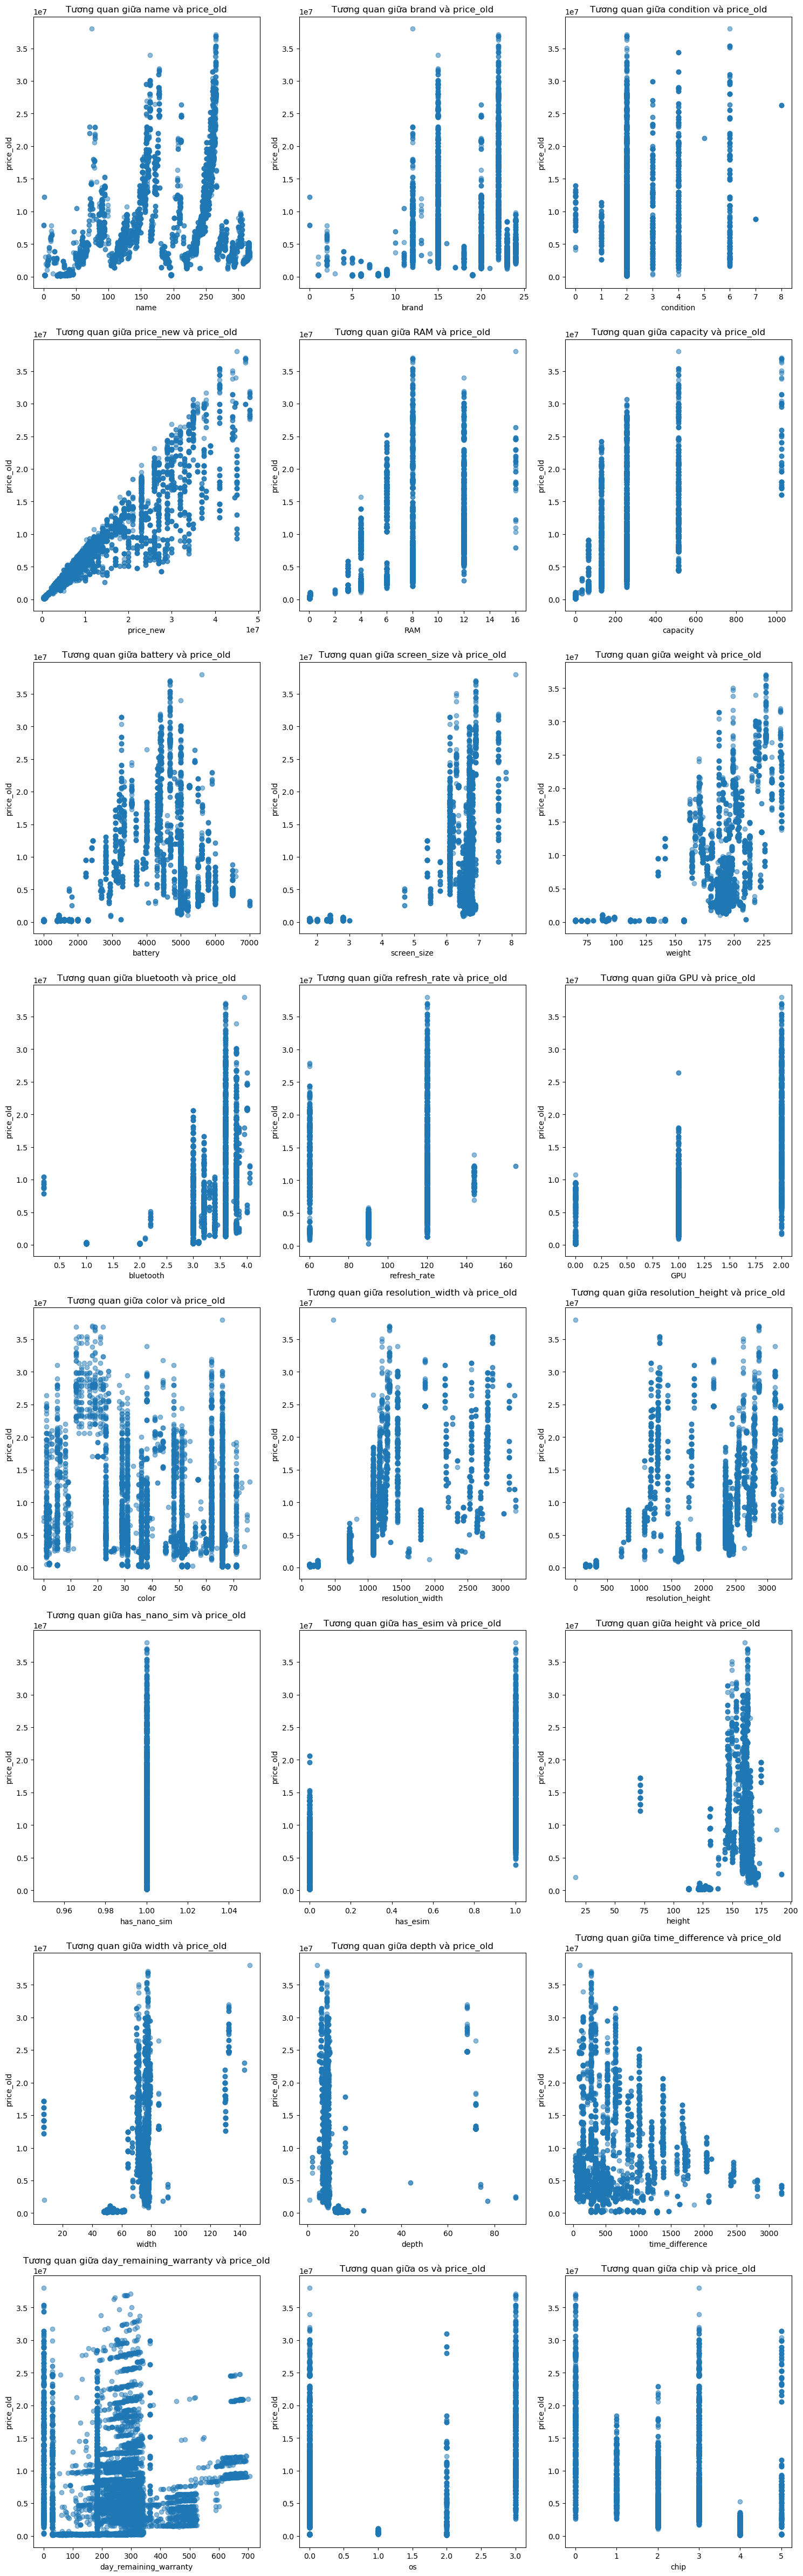

In [23]:
import matplotlib.pyplot as plt

# Lấy danh sách các cột số (ngoại trừ price_old)
numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove("price_old")  # Loại bỏ target khỏi danh sách

# Vẽ tất cả các biểu đồ scatter
fig, axes = plt.subplots(nrows=len(numerical_cols)//3, ncols=3, figsize=(15, len(numerical_cols)*2))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    axes[i].scatter(data[col], data["price_old"], alpha=0.5)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("price_old")
    axes[i].set_title(f"Tương quan giữa {col} và price_old")

plt.tight_layout()
plt.show()

In [24]:
data = data.drop(columns=['has_nano_sim', 'has_esim'])

# Chia tập dữ liệu

In [29]:
from sklearn.model_selection import train_test_split

# Chia dữ liệu thành tập huấn luyện và tập dev + test theo tỷ lệ 60:40
X_train, X_temp, y_train, y_temp = train_test_split(data.drop(columns=['price_old']), data["price_old"], test_size=0.4, random_state=42)

# Chia tiếp tập dev + test thành tập dev (20%) và tập test (20%)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Huấn luyện mô hình

In [26]:
from xgboost import XGBRegressor

# Khởi tạo mô hình XGBoost
model_xgb = XGBRegressor(objective="reg:squarederror", missing=np.nan, random_state=42)

# Huấn luyện mô hình
model_xgb.fit(X_train, y_train)

# Dự đoán
y_pred_xgb = model_xgb.predict(X_test)

In [27]:
y_pred_xgb = model_xgb.predict(X_test)

predictions_df = pd.DataFrame({"Thực tế": y_test, "Dự đoán (XGBoost)": y_pred_xgb})

In [28]:
# Hiển thị toàn bộ kết quả dự đoán
pd.set_option('display.max_rows', None)  # Hiển thị toàn bộ dòng
print(predictions_df)

        Thực tế  Dự đoán (XGBoost)
2019     180000       1.831657e+05
1595    9590000       9.180101e+06
11513  20890000       2.087993e+07
5140    4760000       4.770585e+06
5858    2750000       2.752983e+06
5358    3260000       3.251836e+06
2507   12960000       1.295784e+07
9396    4660000       4.582866e+06
11380    240000       2.166594e+05
7333    2450000       2.489384e+06
2442   12960000       1.295784e+07
5174     150000       1.618035e+05
385    18590000       1.855318e+07
1508    3390000       3.341183e+06
487    16590000       1.657264e+07
2439   12960000       1.295784e+07
2582   12960000       1.295784e+07
7309     270000       2.690240e+05
8911    7390000       7.399573e+06
10210    210000       2.162508e+05
4387   16980000       1.524111e+07
5890    2750000       2.752983e+06
63     22990000       2.294892e+07
11838   4560000       4.518688e+06
3546   24730000       2.473518e+07
7341    2660000       2.574906e+06
6220     430000       4.375576e+05
10880   5700000     

In [41]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,  
    scoring='neg_mean_squared_error', 
    verbose=1,
    n_jobs=-1
)

# Bước 5: Huấn luyện trên tập train
grid_search.fit(X_train, y_train)

# Bước 6: In ra kết quả
print("Best params:", grid_search.best_params_)
print("Best score (negative MSE):", grid_search.best_score_)

# Đánh giá mô hình tốt nhất trên tập dev (validation)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_dev)
mse = mean_squared_error(y_dev, y_pred)
print("MSE on dev set:", mse)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best score (negative MSE): -125329604630.41438
MSE on dev set: 158043866805.2866


In [31]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

random_search = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000200262EEF60>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020022A3FE00>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000200264F1F40>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000200229BB8F0>},
                   scoring='neg_mean_squared_error', verbose=1)

In [32]:
from sklearn.metrics import mean_squared_error

# Dự đoán với mô hình tốt nhất
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_dev)

# Tính MSE
mse = mean_squared_error(y_dev, y_pred)
print("MSE on dev set:", mse)


MSE on dev set: 145753732420.03995


In [33]:
print("Best parameters:", random_search.best_params_)
print("Best score (neg MSE, CV):", random_search.best_score_)
print("MSE on dev set:", mse)


Best parameters: {'colsample_bytree': 0.7450445806718843, 'learning_rate': 0.08400306424731253, 'max_depth': 6, 'n_estimators': 346, 'subsample': 0.9156009253037098}
Best score (neg MSE, CV): -114044840559.84369
MSE on dev set: 145753732420.03995


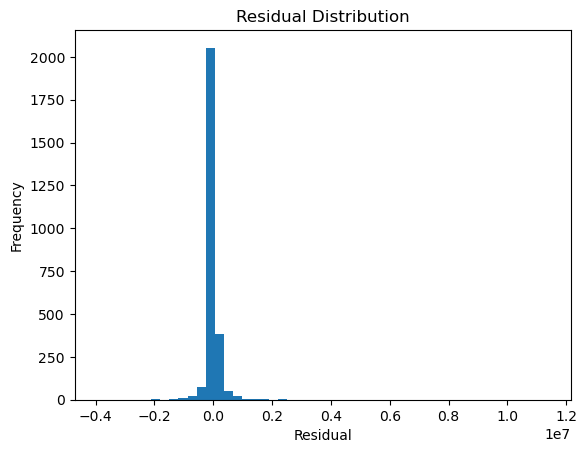

In [35]:
import matplotlib.pyplot as plt

residuals = y_dev - y_pred
plt.hist(residuals, bins=50)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()


In [36]:
import numpy as np
import pandas as pd

# Tính residual
residuals = y_dev - y_pred

# Gộp vào DataFrame để lọc
df_result = pd.DataFrame({
    'actual': y_dev,
    'predicted': y_pred,
    'residual': residuals
})

# Tìm những dòng có sai số lớn nhất
df_result_sorted = df_result.reindex(np.abs(residuals).sort_values(ascending=False).index)
print(df_result_sorted.head(10))  # Xem top 10 sai số lớn nhất


        actual   predicted    residual
1923  37990000  26605242.0  11384758.0
3077  26900000  18495492.0   8404508.0
1981   8060000  11998786.0  -3938786.0
8362  29910000  27177132.0   2732868.0
4519  21980000  24445414.0  -2465414.0
7912  23160000  20753042.0   2406958.0
6817   5040000   7407049.0  -2367049.0
4498  18410000  16087119.0   2322881.0
5386  21180000  18916776.0   2263224.0
4533  25230000  22995346.0   2234654.0


In [37]:
import numpy as np

# Biến đổi y
y_train_log = np.log1p(y_train)
y_dev_log = np.log1p(y_dev)

# Train lại
random_search.fit(X_train, y_train_log)

# Dự đoán và trả về thang ban đầu
y_pred_log = random_search.best_estimator_.predict(X_dev)
y_pred_transformed = np.expm1(y_pred_log)

# Đánh giá lại
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_dev, y_pred_transformed)
mae = mean_absolute_error(y_dev, y_pred_transformed)

print("MSE after log-transform:", mse)
print("MAE after log-transform:", mae)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
MSE after log-transform: 201851816734.93735
MAE after log-transform: 100407.12026228734
